In [1]:
import MetaTrader5 as mt5
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Conectar ao MT5
if not mt5.initialize():
    print("Falha na inicialização do MetaTrader5")
    mt5.shutdown()
    quit()

# Configurar o símbolo e o timeframe
symbol = "IBOV"
timeframe = mt5.TIMEFRAME_M1

In [3]:
# Definir os parâmetros do algoritmo
ema_period_short = 12
ema_period_long = 26
bb_period = 20
bb_deviation = 2
rsi_period = 10

In [4]:
# Método para calcular a EMA curta
def calculate_ema_short(data):
    ema_short = pd.Series(index=data.index)
    ema_short.iloc[0] = data.iloc[0]
    for i in range(1, len(data)):
        ema_short.iloc[i] = (2 / (ema_period_short + 1)) * data.iloc[i] + (1 - 2 / (ema_period_short + 1)) * ema_short.iloc[i-1]
    return ema_short

# Método para calcular a EMA longa
def calculate_ema_long(data):
    ema_long = pd.Series(index=data.index)
    ema_long.iloc[0] = data.iloc[0]
    for i in range(1, len(data)):
        ema_long.iloc[i] = (2 / (ema_period_long + 1)) * data.iloc[i] + (1 - 2 / (ema_period_long + 1)) * ema_long.iloc[i-1]
    return ema_long

# Método para calcular as Bandas de Bollinger
def calculate_bollinger_bands(data):
    sma = data.rolling(bb_period).mean()
    std = data.rolling(bb_period).std()
    upper_band = sma + bb_deviation * std
    lower_band = sma - bb_deviation * std
    return upper_band, sma, lower_band

# Método para calcular o RSI
def calculate_rsi(data):
    delta = data.diff()
    gain = delta.copy()
    gain[gain < 0] = 0
    loss = -delta.copy()
    loss[loss < 0] = 0
    avg_gain = gain.rolling(rsi_period).mean()
    avg_loss = loss.rolling(rsi_period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [5]:
import pytz
from datetime import timezone, datetime

# Obter os dados do símbolo e timeframe
# rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, 200)

timezone = pytz.timezone("Etc/UTC")
utc_from = datetime(2023, 5, 22, hour = 9, tzinfo=timezone)
utc_to = datetime(2023, 5, 22, hour = 13, tzinfo=timezone)

rates = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_to)

In [6]:
# Criar um dataframe com os dados
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

In [7]:
# Calcular os indicadores
ema_short = calculate_ema_short(df['close'])
ema_long = calculate_ema_long(df['close'])
upper_band, sma, lower_band = calculate_bollinger_bands(df['close'])
rsi = calculate_rsi(df['close'])

df['ema_short'] = ema_short
df['ema_long'] = ema_long
df['upper_band'] = upper_band
df['lower_band'] = lower_band
df['sma'] = sma
df['rsi'] = rsi

C:\Users\Anderson\AppData\Local\Temp\ipykernel_22096\4122458189.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ema_short = pd.Series(index=data.index)
C:\Users\Anderson\AppData\Local\Temp\ipykernel_22096\4122458189.py:11: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ema_long = pd.Series(index=data.index)


In [8]:
df.describe()

,open,high,low,close,tick_volume,spread,real_volume,ema_short,ema_long,upper_band,lower_band,sma,rsi
count,181.000000,181.000000,181.000000,181.000000,181.000000,181.0,1.810000e+02,181.000000,181.000000,162.000000,162.000000,162.000000,171.000000
mean,110711.138122,110727.508287,110696.265193,110712.635359,3828.397790,0.0,2.983335e+06,110717.026816,110721.755603,110920.010944,110501.328562,110710.669753,46.327499
std,254.896837,257.898981,249.305137,253.342039,1268.879837,0.0,1.659242e+06,218.394337,181.557214,328.391308,166.696472,219.353332,20.686202
min,110335.000000,110335.000000,110257.000000,110257.000000,26.000000,0.0,7.500000e+03,110492.760750,110547.580667,110639.558389,110282.488440,110497.200000,1.453488
25%,110562.000000,110575.000000,110551.000000,110560.000000,3082.000000,0.0,1.827800e+06,110578.384718,110599.479201,110720.118616,110409.467925,110588.312500,34.409308
50%,110632.000000,110640.000000,110618.000000,110629.000000,3670.000000,0.0,2.635500e+06,110631.967946,110636.478235,110769.014058,110471.798289,110622.875000,47.183099
75%,110749.000000,110765.000000,110743.000000,110753.000000,4400.000000,0.0,3.808800e+06,110748.854146,110743.999594,110892.796933,110540.352526,110744.750000,60.582262
max,111627.000000,111643.000000,111518.000000,111643.000000,10890.000000,0.0,1.160450e+07,111273.700560,111183.479614,111831.665278,111089.104829,111319.000000,89.396067


In [9]:
df

,open,high,low,close,tick_volume,spread,real_volume,ema_short,ema_long,upper_band,lower_band,sma,rsi
time,,,,,,,,,,,,,
2023-05-22 10:00:00,110745.0,110745.0,110744.0,110744.0,32,0,7500,110744.000000,110744.000000,NaN,NaN,NaN,NaN
2023-05-22 10:01:00,110743.0,110743.0,110743.0,110743.0,26,0,33000,110743.846154,110743.925926,NaN,NaN,NaN,NaN
2023-05-22 10:02:00,110744.0,110746.0,110744.0,110746.0,250,0,68500,110744.177515,110744.079561,NaN,NaN,NaN,NaN
2023-05-22 10:03:00,110757.0,110757.0,110743.0,110743.0,340,0,145300,110743.996359,110743.999594,NaN,NaN,NaN,NaN
2023-05-22 10:04:00,110438.0,110438.0,110402.0,110402.0,7516,0,6327600,110691.381534,110718.666290,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-22 12:56:00,110578.0,110610.0,110578.0,110610.0,2841,0,1426200,110578.272848,110609.014645,110665.035299,110503.264701,110584.15,61.434978
2023-05-22 12:57:00,110565.0,110579.0,110565.0,110579.0,4060,0,2776100,110578.384718,110606.791338,110655.065911,110506.034089,110580.55,55.465587
2023-05-22 12:58:00,110591.0,110638.0,110591.0,110638.0,2914,0,1670000,110587.556300,110609.103091,110651.227269,110508.272731,110579.75,71.014493


In [10]:
# Imprimir os resultados no console
print("Preço: \n", df['close'])
print("EMA Short: \n", ema_short)
print("EMA Long: \n", ema_long)
print("SMA: \n", sma)
print("Upper Band: \n", upper_band)
print("Lower Band: \n", lower_band)
print("RSI: \n", rsi)

Preço: 
 time
2023-05-22 10:00:00    110744.0
2023-05-22 10:01:00    110743.0
2023-05-22 10:02:00    110746.0
2023-05-22 10:03:00    110743.0
2023-05-22 10:04:00    110402.0
                         ...   
2023-05-22 12:56:00    110610.0
2023-05-22 12:57:00    110579.0
2023-05-22 12:58:00    110638.0
2023-05-22 12:59:00    110616.0
2023-05-22 13:00:00    110641.0
Name: close, Length: 181, dtype: float64
EMA Short: 
 time
2023-05-22 10:00:00    110744.000000
2023-05-22 10:01:00    110743.846154
2023-05-22 10:02:00    110744.177515
2023-05-22 10:03:00    110743.996359
2023-05-22 10:04:00    110691.381534
                           ...      
2023-05-22 12:56:00    110578.272848
2023-05-22 12:57:00    110578.384718
2023-05-22 12:58:00    110587.556300
2023-05-22 12:59:00    110591.932254
2023-05-22 13:00:00    110599.481138
Length: 181, dtype: float64
EMA Long: 
 time
2023-05-22 10:00:00    110744.000000
2023-05-22 10:01:00    110743.925926
2023-05-22 10:02:00    110744.079561
2023-05-22 1

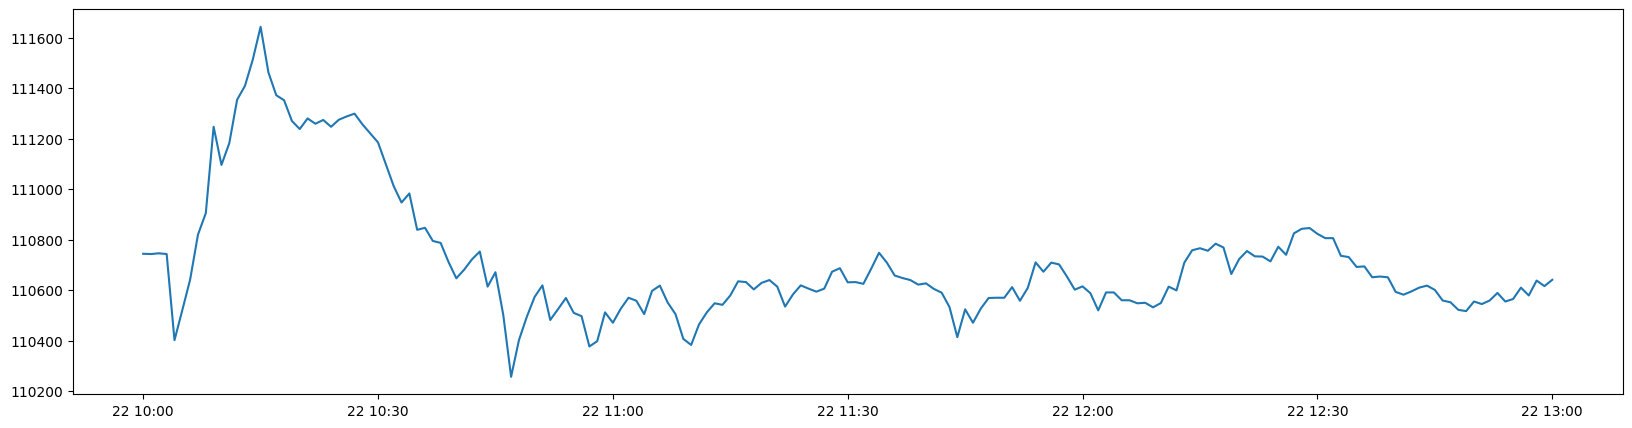

In [11]:
plt.figure(figsize=(20, 5))
plt.plot(df['close'])

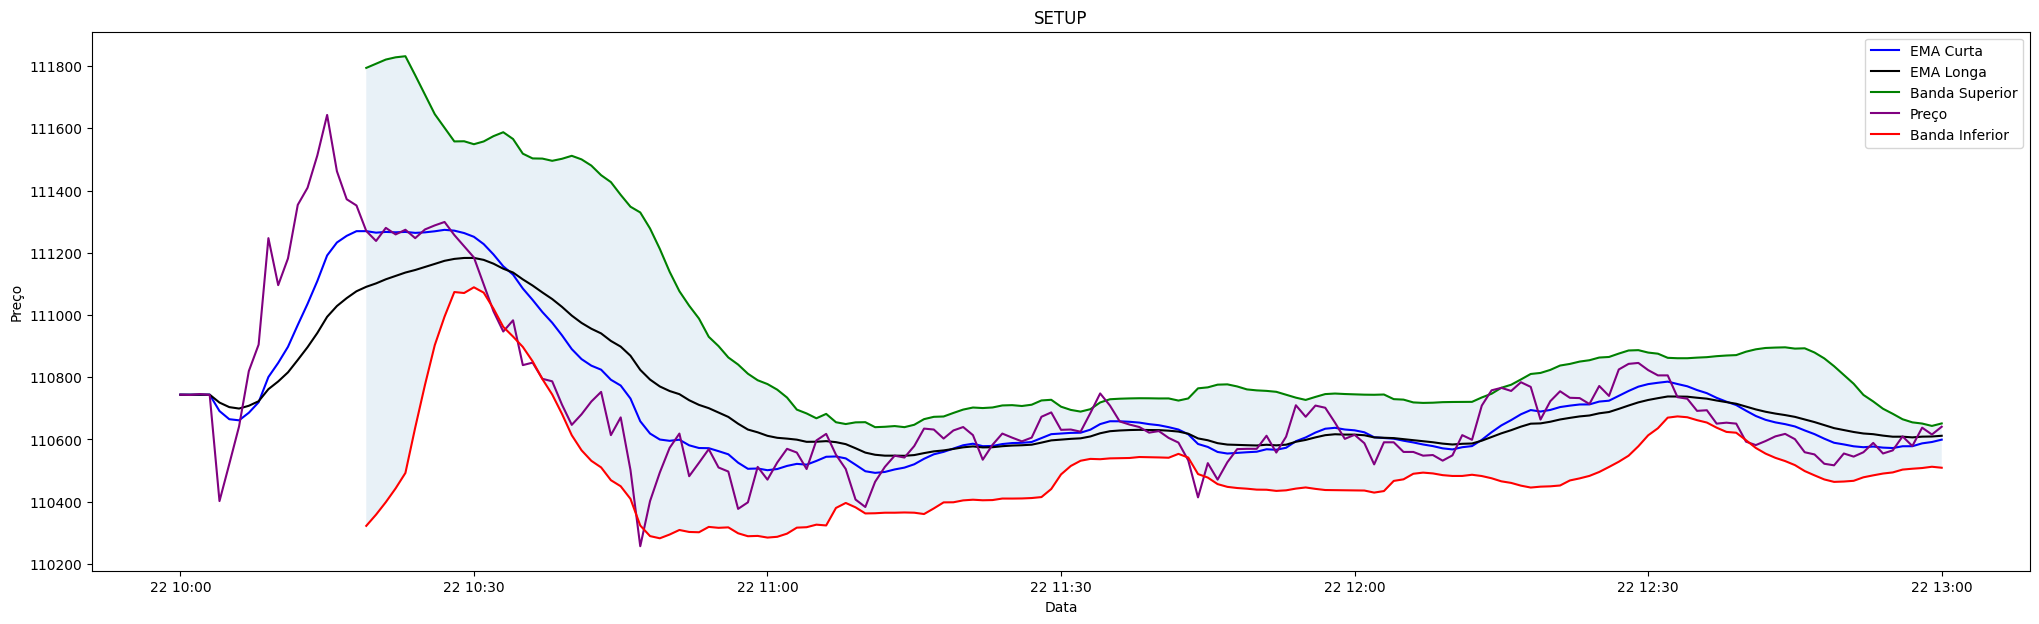

In [12]:
#Plotar os resultados
plt.figure(figsize=(25, 7))
plt.plot(ema_short, color='blue')
plt.plot(ema_long, color='black')
plt.plot(upper_band, color='green')
plt.plot(df['close'], color='purple')
plt.plot(lower_band, color='red')
plt.fill_between(df.index, lower_band, upper_band, alpha=0.1)
plt.title('SETUP')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend(['EMA Curta', 'EMA Longa', 'Banda Superior', 'Preço', 'Banda Inferior'])
plt.show()

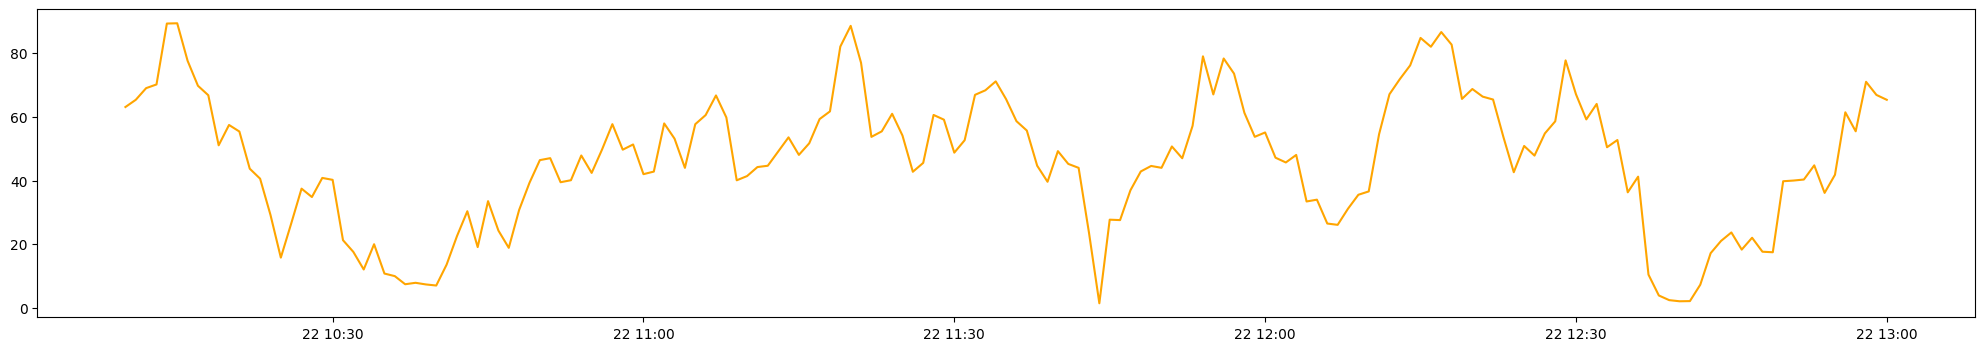

In [13]:
plt.figure(figsize=(25, 4))
plt.plot(rsi, color='orange')

<AxesSubplot:xlabel='time'>

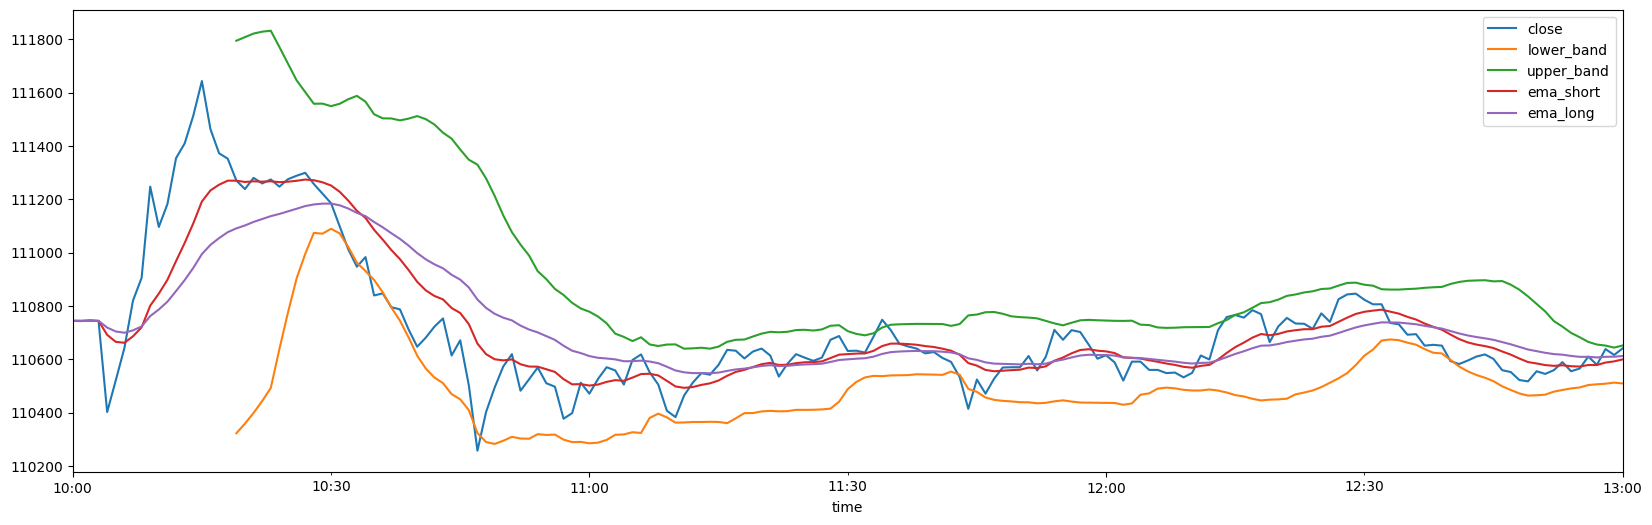

In [14]:
df[['close','lower_band', 'upper_band', 'ema_short', 'ema_long']].plot(figsize=(20, 6))

In [15]:
import cufflinks as cf
cf.go_offline()

In [16]:
df.iplot(kind='candle')

In [17]:
qf = cf.QuantFig(df, title='Setup', legend='top', name='Candlestick')
qf.add_bollinger_bands(periods=20,boll_std=2)
qf.add_rsi(periods=20,color='java')
qf.add_macd()
qf.iplot()

In [18]:
#Do vídeo: df = Criando Candlestick com Python Matplotlib
import mplfinance as mpf
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [19]:
print(mpf.available_styles())

['binance', 'blueskies', 'brasil', 'charles', 'checkers', 'classic', 'default', 'ibd', 'kenan', 'mike', 'nightclouds', 'sas', 'starsandstripes', 'yahoo']


In [20]:
df_sem_indicadores = pd.DataFrame(rates)
df_sem_indicadores['time'] = pd.to_datetime(df_sem_indicadores['time'], unit='s')
df_sem_indicadores.set_index('time', inplace=True)

In [21]:
df_sem_indicadores

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2023-05-22 10:00:00,110745.0,110745.0,110744.0,110744.0,32,0,7500
2023-05-22 10:01:00,110743.0,110743.0,110743.0,110743.0,26,0,33000
2023-05-22 10:02:00,110744.0,110746.0,110744.0,110746.0,250,0,68500
2023-05-22 10:03:00,110757.0,110757.0,110743.0,110743.0,340,0,145300
2023-05-22 10:04:00,110438.0,110438.0,110402.0,110402.0,7516,0,6327600
...,...,...,...,...,...,...,...
2023-05-22 12:56:00,110578.0,110610.0,110578.0,110610.0,2841,0,1426200
2023-05-22 12:57:00,110565.0,110579.0,110565.0,110579.0,4060,0,2776100
2023-05-22 12:58:00,110591.0,110638.0,110591.0,110638.0,2914,0,1670000


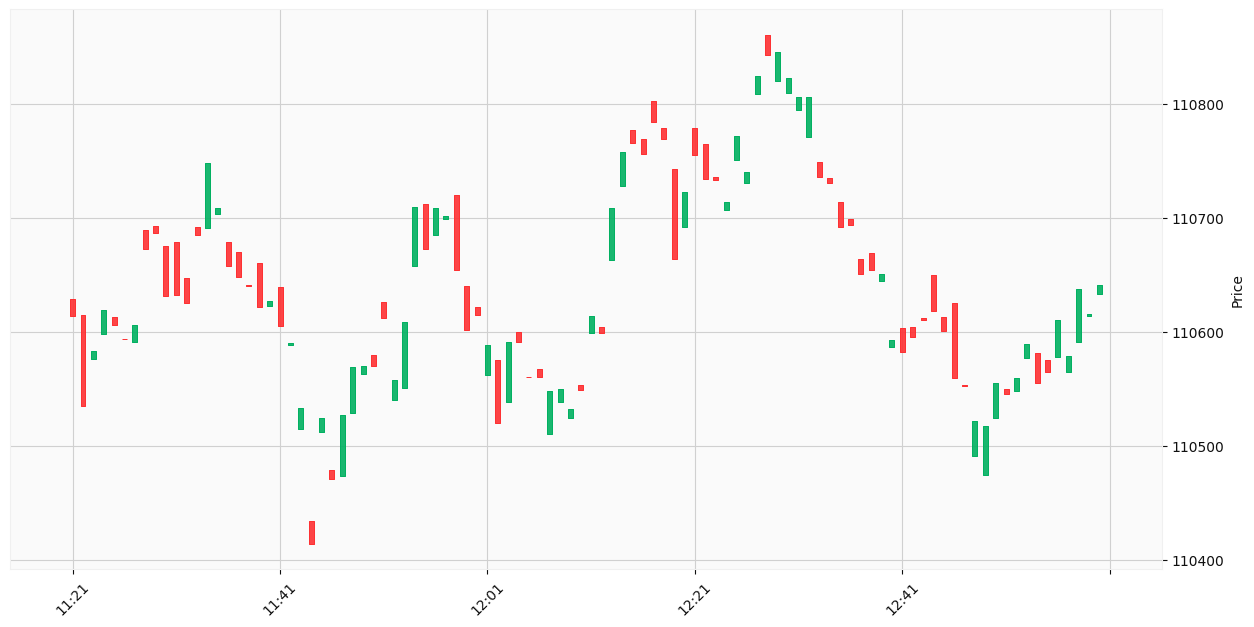

In [22]:
mpf.plot(df_sem_indicadores.tail(100), type='candle', figsize=(16, 8), style='yahoo')

In [23]:
df

,open,high,low,close,tick_volume,spread,real_volume,ema_short,ema_long,upper_band,lower_band,sma,rsi
time,,,,,,,,,,,,,
2023-05-22 10:00:00,110745.0,110745.0,110744.0,110744.0,32,0,7500,110744.000000,110744.000000,NaN,NaN,NaN,NaN
2023-05-22 10:01:00,110743.0,110743.0,110743.0,110743.0,26,0,33000,110743.846154,110743.925926,NaN,NaN,NaN,NaN
2023-05-22 10:02:00,110744.0,110746.0,110744.0,110746.0,250,0,68500,110744.177515,110744.079561,NaN,NaN,NaN,NaN
2023-05-22 10:03:00,110757.0,110757.0,110743.0,110743.0,340,0,145300,110743.996359,110743.999594,NaN,NaN,NaN,NaN
2023-05-22 10:04:00,110438.0,110438.0,110402.0,110402.0,7516,0,6327600,110691.381534,110718.666290,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-22 12:56:00,110578.0,110610.0,110578.0,110610.0,2841,0,1426200,110578.272848,110609.014645,110665.035299,110503.264701,110584.15,61.434978
2023-05-22 12:57:00,110565.0,110579.0,110565.0,110579.0,4060,0,2776100,110578.384718,110606.791338,110655.065911,110506.034089,110580.55,55.465587
2023-05-22 12:58:00,110591.0,110638.0,110591.0,110638.0,2914,0,1670000,110587.556300,110609.103091,110651.227269,110508.272731,110579.75,71.014493


<AxesSubplot:xlabel='time'>

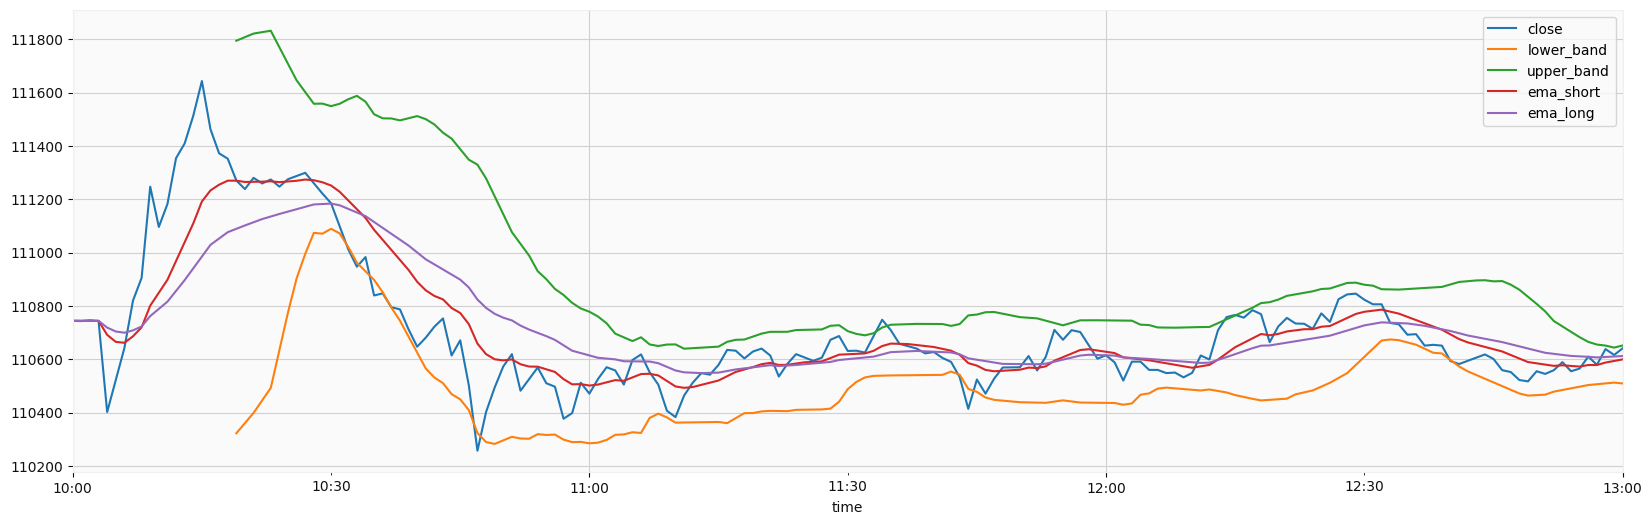

In [24]:
df[['close','lower_band', 'upper_band', 'ema_short', 'ema_long']].plot(figsize=(20, 6))

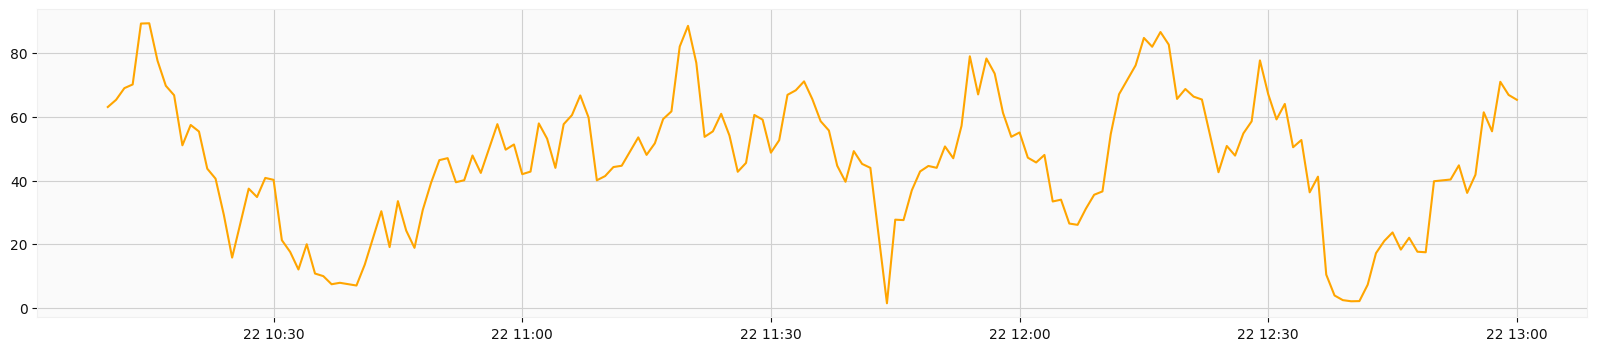

In [25]:
plt.figure(figsize=(20, 4))
plt.plot(rsi, color='orange')

In [26]:
# Calcular os sinais de compra e venda
df["signal"] = 0
df.loc[(df["ema_short"] > df["ema_long"]) & (df["close"] < df["lower_band"]) & (df["rsi"] < 30), "signal"] = 1
df.loc[(df["ema_short"] < df["ema_long"]) & (df["close"] > df["upper_band"]) & (df["rsi"] > 70), "signal"] = -1

<AxesSubplot:xlabel='time'>

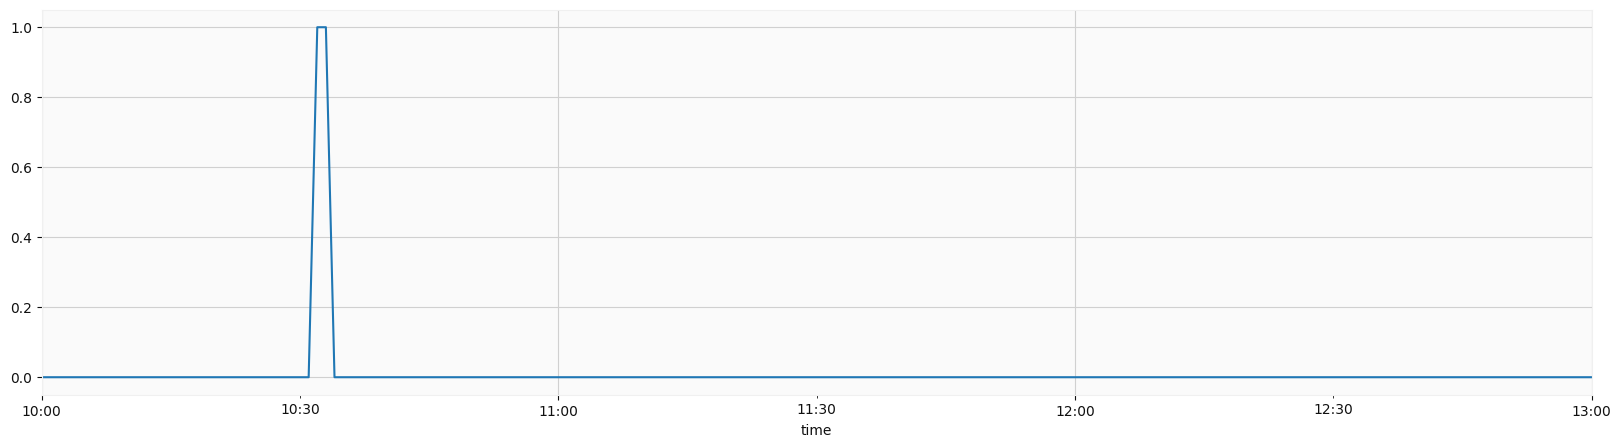

In [27]:
df["signal"].plot(figsize=(20, 5))

In [28]:
# Calcular os sinais de compra e venda
df["signal"] = 0
df.loc[(df["close"] < df["lower_band"]) & (df["rsi"] < 30), "signal"] = 1
df.loc[(df["close"] > df["upper_band"]) & (df["rsi"] > 70), "signal"] = -1

<AxesSubplot:xlabel='time'>

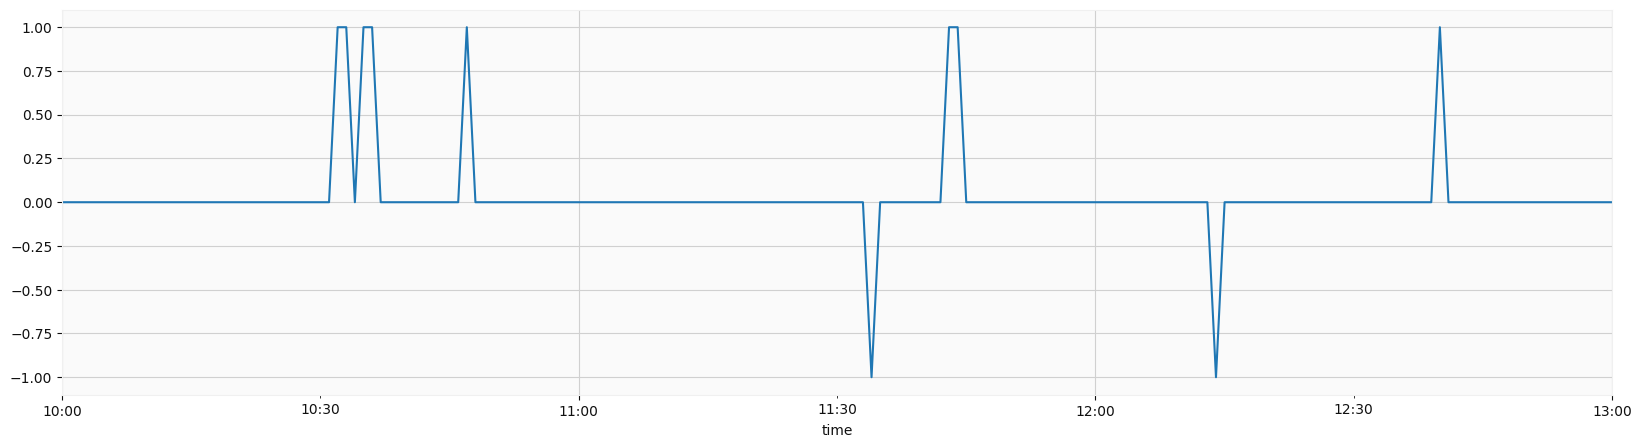

In [29]:
df["signal"].plot(figsize=(20, 5))

In [30]:
# import time
#
# lot_size = 1000
# initial_balance = 10000
# # lot = 0.10
# # result = 0
# # order = None
# # price = None
# request = {}
#
# # df['ema_short'] = df['close'].ewm(span=ema_period_short, adjust=False).mean()
# # df['ema_long'] = df['close'].ewm(span=ema_period_long, adjust=False).mean()
# # df['bb_upper'], df['bb_middle'], df['bb_lower'] = \
# #     ta.bollinger_bands(df['close'], bb_period, bb_deviation)
# # df['rsi'] = ta.rsi(df['close'], rsi_period)
#
# # Definição da estratégia de investimento
# df['signal'] = 0
# df.loc[(df['ema_short'] > df['ema_long']) &
#          (df['close'] < df['lower_band']) &
#          (df['rsi'] < 30), 'signal'] = 1
# df.loc[(df['ema_short'] < df['ema_long']) &
#          (df['close'] > df['upper_band']) &
#          (df['rsi'] > 70), 'signal'] = -1
#
# # Criação de um novo DataFrame com informações sobre as operações de compra/venda
# positions = pd.DataFrame(index=df.index)
# positions['signal'] = df['signal']
# positions['close'] = df['close']
# positions['rsi'] = df['rsi']
# positions['bb_upper'] = df['upper_band']
# positions['bb_middle'] = df['sma']
# positions['bb_lower'] = df['lower_band']
# positions['ema_short'] = df['ema_short']
# positions['ema_long'] = df['ema_long']
# positions['position'] = positions['signal'].diff()
# positions['position'].iloc[0] = positions['signal'].iloc[0]
# positions = positions[positions['position'] != 0]
#
# # Realização do backtesting
# balance = initial_balance
# trades = []
# for i, row in positions.iterrows():
#     print("aqui")
#     if row['position'] == 1:
#         order = mt5.ORDER_TYPE_BUY
#         price = mt5.symbol_info_tick(symbol).ask
#         print(f"Compra realizada em {i} por {price}")
#     elif row['position'] == -1:
#         order = mt5.ORDER_TYPE_SELL
#         price = mt5.symbol_info_tick(symbol).bid
#         print(f"Venda realizada em {i} por {price}")
#
#     lot = lot_size
#     request = {
#         "action": mt5.TRADE_ACTION_DEAL,
#         "symbol": symbol,
#         "volume": lot,
#         "type": order,
#         "price": price,
#         "deviation": 100,
#         "magic": 123456,
#         "comment": "Python script open",
#         "type_time": mt5.ORDER_TIME_GTC,
#         "type_filling": mt5.ORDER_FILLING_IOC,
#     }
#
# # Envio da ordem de compra ou venda
# result = mt5.order_send(request)
#
# if result.retcode != mt5.TRADE_RETCODE_DONE:
#     print(f"Erro ao enviar ordem: {result.comment}")
#
# # Se a ordem foi enviada com sucesso, aguarda sua execução
# while True:
#     # Configurar o símbolo e o timeframe
#     symbol = "EURUSD"
#     timeframe = mt5.TIMEFRAME_M5
#
#     # Obter os dados do símbolo e timeframe
#     rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, 100)
#
#     # Obtém informações sobre a ordem
#     order = mt5.orders_get(result.order)
#
#     print("ESPERANDO EXECUÇÃO DA ORDEM")
#
#     if order == mt5.TRADE_RETCODE_DONE:
#         break
# #     time.sleep(1)ff

In [31]:
# import time
#
#
# symbol = "EURUSD"
# lot = 0.1
# magic_number = 123456
# comment = "Signal from Python"
#
# # get the current price
# price = mt5.symbol_info_tick(symbol).ask
#
# # open a position
# request = {
#     "action": mt5.TRADE_ACTION_DEAL,
#     "symbol": symbol,
#     "volume": lot,
#     "type": mt5.ORDER_TYPE_BUY,
#     "price": price,
#     "magic": magic_number,
#     "comment": comment,
#     "type_time": mt5.ORDER_TIME_GTC,
#     "type_filling": mt5.ORDER_FILLING_FOK,
# }
# result = mt5.order_send(request)
# if result.retcode != mt5.TRADE_RETCODE_DONE:
#     print("order_send failed, retcode={}".format(result.retcode))
#     mt5.shutdown()
#     quit()
#
# # wait for the order to be filled
# while True:
#     deals = mt5.history_deals_get(symbol=symbol)
#     if len(deals) > 0:
#         last_deal = deals[-1]
#         if last_deal.magic == magic_number and last_deal.entry == mt5.DEAL_ENTRY_IN:
#             print("Position opened: ticket={}".format(last_deal.order))
#             break
#     time.sleep(1)

In [32]:
#Portfolio para backtesting
#Setup RSI, BB, EMA
import vectorbt as vbt

buy_signal = (df["ema_short"] > df["ema_long"])
sell_signal = (df["ema_short"] < df["ema_long"])

pf = vbt.Portfolio.from_signals(df['close'], buy_signal, sell_signal, init_cash=10000)

In [33]:
pf.plot().show()

In [34]:
pf.stats()

Start                         2023-05-22 10:00:00
End                           2023-05-22 13:00:00
Period                            0 days 03:01:00
Start Value                               10000.0
End Value                             9951.412014
Total Return [%]                         -0.48588
Benchmark Return [%]                    -0.093007
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                         0.847891
Max Drawdown Duration             0 days 02:45:00
Total Trades                                    5
Total Closed Trades                             5
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                  0.0
Best Trade [%]                          -0.002709
Worst Trade [%]                          -0.23731
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                    -0.097335
